In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.svm as skl

from pandas.io.parsers import read_csv
from scipy.io import loadmat
from scipy.optimize import minimize

In [2]:
def load_csv(file_name):
    # CSV to DataFrame
    data = read_csv(file_name).to_numpy()
    return data[:,1:]

In [3]:
train = load_csv('data/processed/train_processed.csv')
validation = load_csv('data/processed/validation_processed.csv')
test = load_csv('data/processed/test_processed.csv')
X_train = train[:,:-1]
y_train = train[:,-1]
y_train = np.expand_dims(y_train, axis= 1)
X_validation = validation[:,:-1]
y_validation = validation[:,-1]
X_test = test[:,:-1]
y_test = test[:,-1]

In [4]:
# Calcula el valor de la función sigmoide
def sigmoid(X):
    z = 1/(1 + np.exp(-X))
    return z

In [5]:
# Propagación hacia delante
def forward_propagation(Theta1, Theta2, X):
    m = X.shape[0]

    # Input Layer
    a1 = np.hstack([np.ones([m, 1]), X])
    # Hidden Layer
    z2 = np.matmul(a1, Theta1.T)
    a2 = np.hstack([np.ones([m, 1]), sigmoid(z2)])
    # Output Layer
    z3 = np.matmul(a2, Theta2.T)
    a3 = sigmoid(z3)
    
    return a1, a2, a3

In [6]:
# Función de coste
def cost(Theta1, Theta2, X, y):
    a1, a2, H = forward_propagation(Theta1, Theta2, X)
    Term1 = y * np.log(H)
    Term2 =  (1 - y) * np.log(1 - H)
    coste = (- 1 / (len(y))) * np.sum(Term1 + Term2)

    return coste

In [7]:
# Función de coste con regularización
def cost_reg(Theta1, Theta2, X, y, lam):
    coste = cost(Theta1, Theta2, X, y)
    Term3 = np.sum(np.square(Theta1[:,1:])) + np.sum(np.square(Theta2[:,1:]))     
    coste += (lam / (2 * len(y))) * Term3
    
    return coste

In [8]:
# Función que calcula la propagación hacia atrás
def back_propagation(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    
    # backprop devuelve una tupla (coste, gradiente) con el coste y el gradiente de
    # una red neuronal de tres capas, con num_entradas, num_ocultas nodos en la capa
    # oculta y num_etiquetas nodos en la capa de salida. Si m es el número de ejemplos
    # de entrenamiento, la dimensión de ’X’ es (m, num_entradas) y la de ’y’ es
    # (m, num_etiquetas)
    
    # Theta1 y Theta2 están codificados como un array unidimensional
    Theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    Theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))
    m = len(y)
    
    # Matrices para almacenar el gradiente con las mismas dimensiones que Theta1 y Theta2
    Delta1 = np.zeros(np.shape(Theta1))
    Delta2 = np.zeros(np.shape(Theta2))
    
    # Propagación hacia delante
    a1, a2, H = forward_propagation(Theta1, Theta2, X)
    # Contribución de cada nodo al error de la salida
    d3 = H - y
    d2 = (np.dot(d3,Theta2) * (a2 * (1 - a2)))[:,1:]  
    Delta1 = np.dot(d2.T, a1)
    Delta2 = np.dot(d3.T, a2)
    
    # Añadimos regularización
    Delta1 = Delta1/m
    Delta2 = Delta2/m
    Delta1[:,1:] = Delta1[:,1:] + (reg/m)*Theta1[:,1:]
    Delta2[:,1:] = Delta2[:,1:] + (reg/m)*Theta2[:,1:]
    
    # Devolvemos el coste y el gradiente
    coste = cost_reg(Theta1, Theta2, X, y,reg)
    grad = np.concatenate((np.ravel(Delta1),np.ravel(Delta2)))
    
    return coste, grad 

In [9]:
# Entrena una red neuronal con reg como término de regularización y num_iters como número de iteraciones
def training(reg, num_iters,params_rn,num_entradas,num_ocultas,num_etiquetas,X,y_onehot):
    
    # Entrenamos la red neuronal
    fmin = minimize(fun=back_propagation, x0=params_rn,
                args=(num_entradas, num_ocultas,
                num_etiquetas, X, y_onehot, reg),
                method='TNC', jac=True,
                options={'maxiter': num_iters})

    # Reordenamos Theta1 y Theta2
    Theta1 = np.reshape(fmin.x[:num_ocultas*(num_entradas + 1)],(num_ocultas,(num_entradas + 1)))
    Theta2 = np.reshape(fmin.x[num_ocultas * (num_entradas+1):],(num_etiquetas,(num_ocultas + 1)))
    result = forward_propagation(Theta1,Theta2, X)[2]
    
    return result

In [10]:
# Calcula el porcentaje de aciertos de un resultado
def success_rate(resul,y):
    
    predicciones = []
    for i in range(len(result)):
        predicciones.append(np.argmax(result[i])+1)
    
    aciertos = 0
    for i in range(len(y)):
        if (predicciones[i] == y[i]):
            aciertos +=1
            
    return (aciertos/len(y)*100)

In [11]:
eInit = 0.12
num_entradas = X_train.shape[1]
num_ocultas = 25  # puesto al azar
num_etiquetas = 1
theta1 = np.random.random((num_ocultas,(num_entradas + 1)))*(2*eInit) - eInit
theta2 = np.random.random((num_etiquetas,(num_ocultas + 1)))*(2*eInit) - eInit
params_rn = np.concatenate((np.ravel(theta1), np.ravel(theta2)))

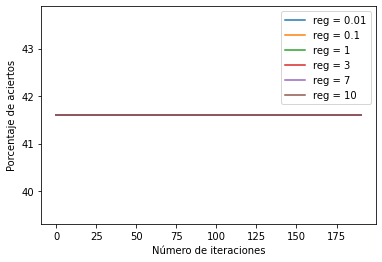

In [12]:
reg_terms = [0.01, 0.1, 1, 3, 7, 10]
iter_terms = np.arange(0, 200, 10)

for reg in reg_terms:
    porcentajes = []
    for iters in iter_terms:
        result = training(reg, iters,params_rn,num_entradas,num_ocultas,num_etiquetas, X_train,y_train)
        porcentajes.append(success_rate(result,y_validation))
    
    # Pintamos la gráfica
    plt.plot(iter_terms, porcentajes, label='reg = ' + str(reg))

plt.xlabel("Número de iteraciones")
plt.ylabel("Porcentaje de aciertos")
plt.legend()
plt.show()